In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import os
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
def VGG_block(num_convs, in_channels, out_channels):
    blk = []
    for _ in range(num_convs):
        blk.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        blk.append(nn.ReLU())
        in_channels = out_channels
    blk.append(nn.MaxPool2d(kernel_size=2, stride=2))
    
    return nn.Sequential(*blk)

def VGG(conv_arch):
    conv_blks = []
    in_channels = 1
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(VGG_block(num_convs, in_channels, out_channels))
        in_channels = out_channels

    return nn.Sequential(
        *conv_blks, nn.Flatten(),
        nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 10)
    )

def predict(image, net):
    net.eval()
    image = image.reshape(1, 1, 224, 224)
    result = net(image)
    
    return F.softmax(result, dim=1).argmax(dim=1)

In [3]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))
net = VGG(conv_arch)

trainer = torch.optim.SGD(net.parameters(), lr=0.1, weight_decay=5e-4)

In [4]:
checkpoint = torch.load('VGG_checkpoint_epoch40.pt', map_location=torch.device('cpu'))
net.load_state_dict(checkpoint['model_state_dict'])
trainer.load_state_dict(checkpoint['optimizer_state_dict'])
num_epochs = checkpoint['epoch']

torch.Size([1, 1, 224, 224])
tensor([[[[205., 205., 205.,  ..., 205., 205., 205.],
          [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
          [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
          ...,
          [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
          [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
          [  0.,   0.,   0.,  ...,   0.,   0.,   0.]]]])
tensor([3])


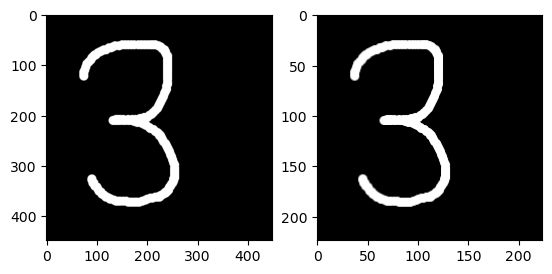

In [6]:
import cv2

net.eval()
image = cv2.imread('image.png')
image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
image = 255 - image

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')

image = cv2.resize(image, (224, 224))

plt.subplot(1, 2, 2)
plt.imshow(image, cmap='gray')

image = torch.tensor(image, dtype=torch.float32).reshape(1, 1, 224, 224)
print(image.shape)
print(image)
print(predict(image, net))

In [5]:
MNIST_train = torchvision.datasets.MNIST(
    root='data',train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224))
    ])
)

MNIST_train = torchvision.datasets.MNIST(
    root='data',train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224))
    ])
)

In [25]:
len(MNIST_train)

10000

the ground true label is 1
the predicte label is tensor([1])


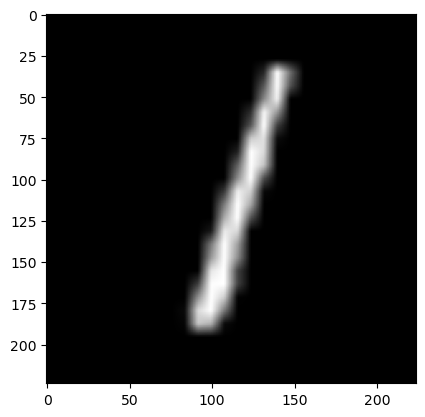

In [12]:
a = 2

image = MNIST_train[a][0]
image = image.reshape(224, 224)
label = MNIST_train[a][1]

plt.imshow(image.reshape(224, 224), cmap='gray')

print(f'the ground true label is {label}')
print(f'the predicte label is {predict(image, net)}')

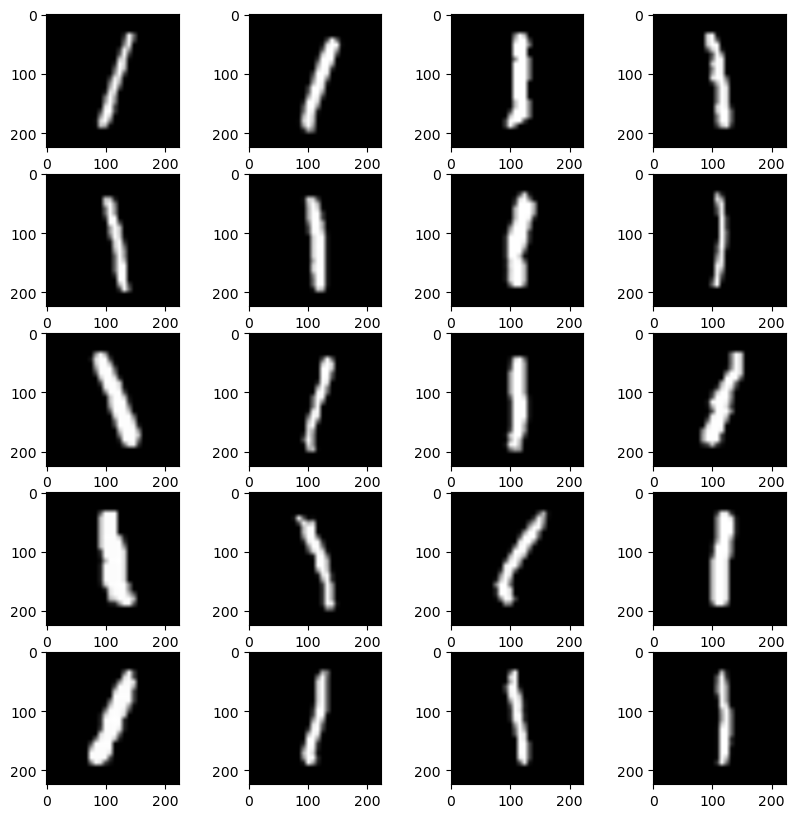

In [18]:
# get 5 labeled 1 images and subplot

fig = plt.figure(figsize=(10, 10))
a = 0

for i in range(len(MNIST_train)):
    image = MNIST_train[i][0]
    label = MNIST_train[i][1]
    if label == 1:
        a += 1
        fig.add_subplot(5, 4, a)
        plt.imshow(image.reshape(224, 224), cmap='gray')
        if a == 20:
            break

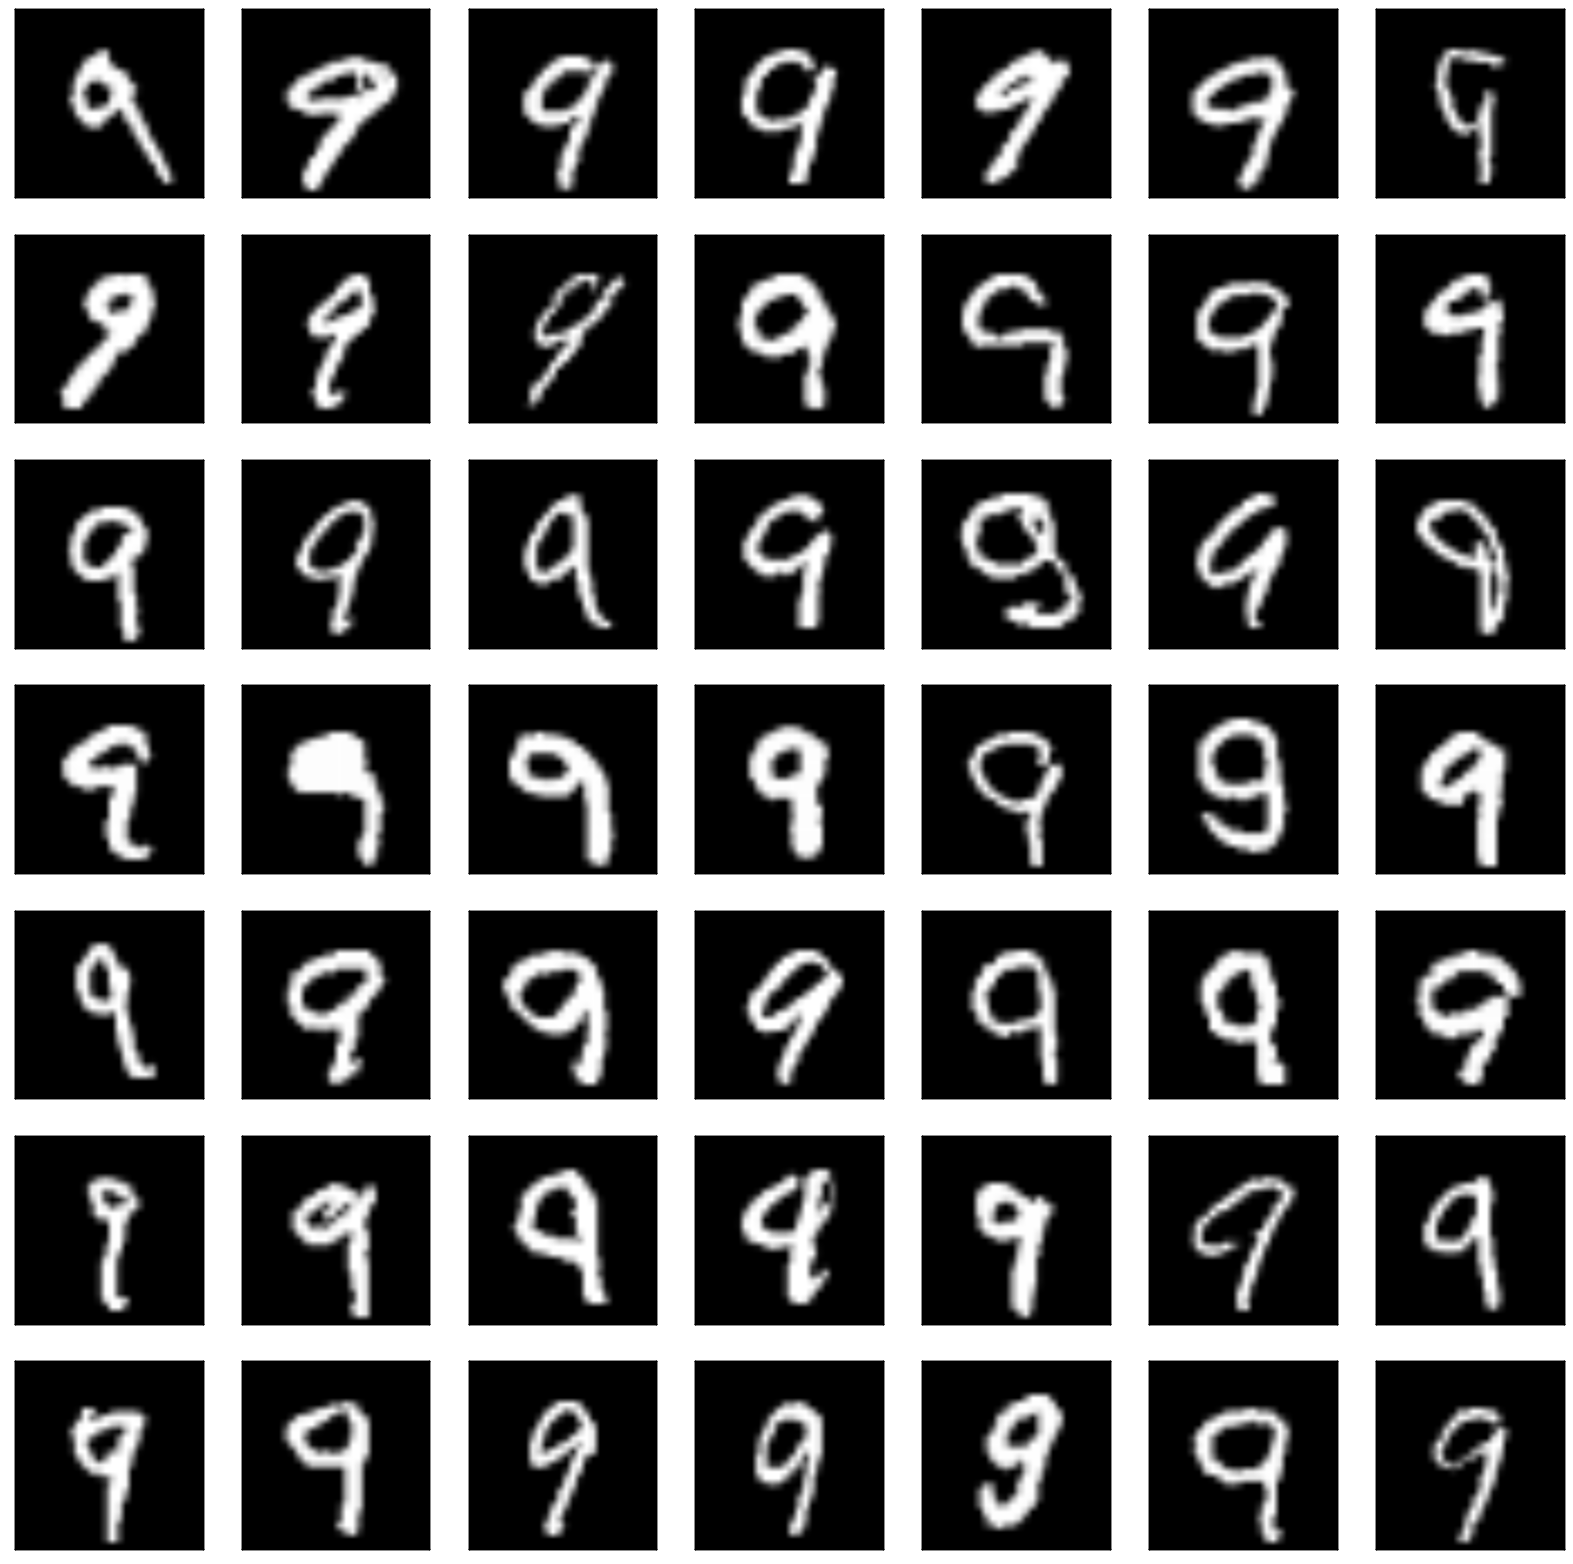

In [6]:
fig = plt.figure(figsize=(20, 20))


for l in range(10):
    a = 0
    for i in range(len(MNIST_train)):
        name = f'label_{l}.png'
        image = MNIST_train[i][0]
        label = MNIST_train[i][1]
        
        if label == l:
            a += 1
            fig.add_subplot(7, 7, a)
            plt.imshow(image.reshape(224, 224), cmap='gray')
            plt.xticks([])
            plt.yticks([])
            if a == 49:
                plt.savefig(name)
                break
            

In [15]:
error_dict = {}

for a in range(10000):
    image = MNIST_train[a][0]
    image = image.reshape(224, 224)
    label = MNIST_train[a][1]

    if label != predict(image, net):
        error_dict[a] = (label, predict(image, net))

In [42]:
# save
path = os.path.join('error_dict_VGG.txt')

with open(path, 'w') as f:
    for key, value in error_dict.items():
        f.write(f'{key} {value[0]} {value[1]}\n')

In [18]:
# load
error_dict = {}

path = os.path.join('error_dict_VGG.txt')

with open(path, 'r') as f:
    for line in f:
        key, value1, value2 = line.split()
        error_dict[int(key)] = (int(value1), int(value2))

Text(0, 0.5, 'times of occurence')

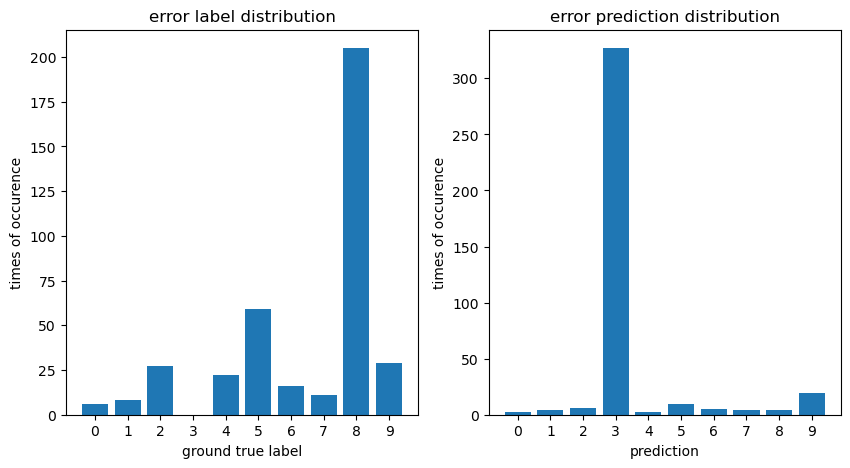

In [44]:
# count: {value: times of occurence}
error_label = {}
for value in error_dict:
    error_label[error_dict[value][0]] = error_label.get(error_dict[value][0], 0) + 1

error_prediction = {}
for value in error_dict:
    error_prediction[error_dict[value][1]] = error_prediction.get(error_dict[value][1], 0) + 1

# plot
plt.rcParams['figure.figsize'] = [10, 5]

plt.subplot(1, 2, 1)
plt.bar(error_label.keys(), error_label.values())
plt.xticks(range(10))
plt.title('error label distribution')
plt.xlabel('ground true label')
plt.ylabel('times of occurence')

plt.subplot(1, 2, 2)
plt.bar(error_prediction.keys(), error_prediction.values())
plt.xticks(range(10))
plt.title('error prediction distribution')
plt.xlabel('prediction')
plt.ylabel('times of occurence')

In [28]:
label_dicts = {}
for i in range(10):
    label_dicts[f'label_dict_{i}'] = {}

for key in error_dict:
    label, prediction = error_dict[key]
    label_dicts[f'label_dict_{label}'][prediction] = label_dicts[f'label_dict_{label}'].get(prediction, 0) + 1

In [29]:
label_dicts

{'label_dict_0': {3: 4, 8: 1, 6: 1},
 'label_dict_1': {3: 7, 2: 1},
 'label_dict_2': {3: 24, 7: 3},
 'label_dict_3': {},
 'label_dict_4': {9: 17, 2: 1, 6: 2, 8: 1, 7: 1},
 'label_dict_5': {3: 57, 2: 1, 6: 1},
 'label_dict_6': {0: 2, 5: 6, 1: 2, 8: 2, 4: 1, 3: 3},
 'label_dict_7': {3: 5, 2: 3, 1: 2, 9: 1},
 'label_dict_8': {3: 201, 9: 1, 5: 3},
 'label_dict_9': {3: 26, 4: 1, 6: 1, 5: 1}}

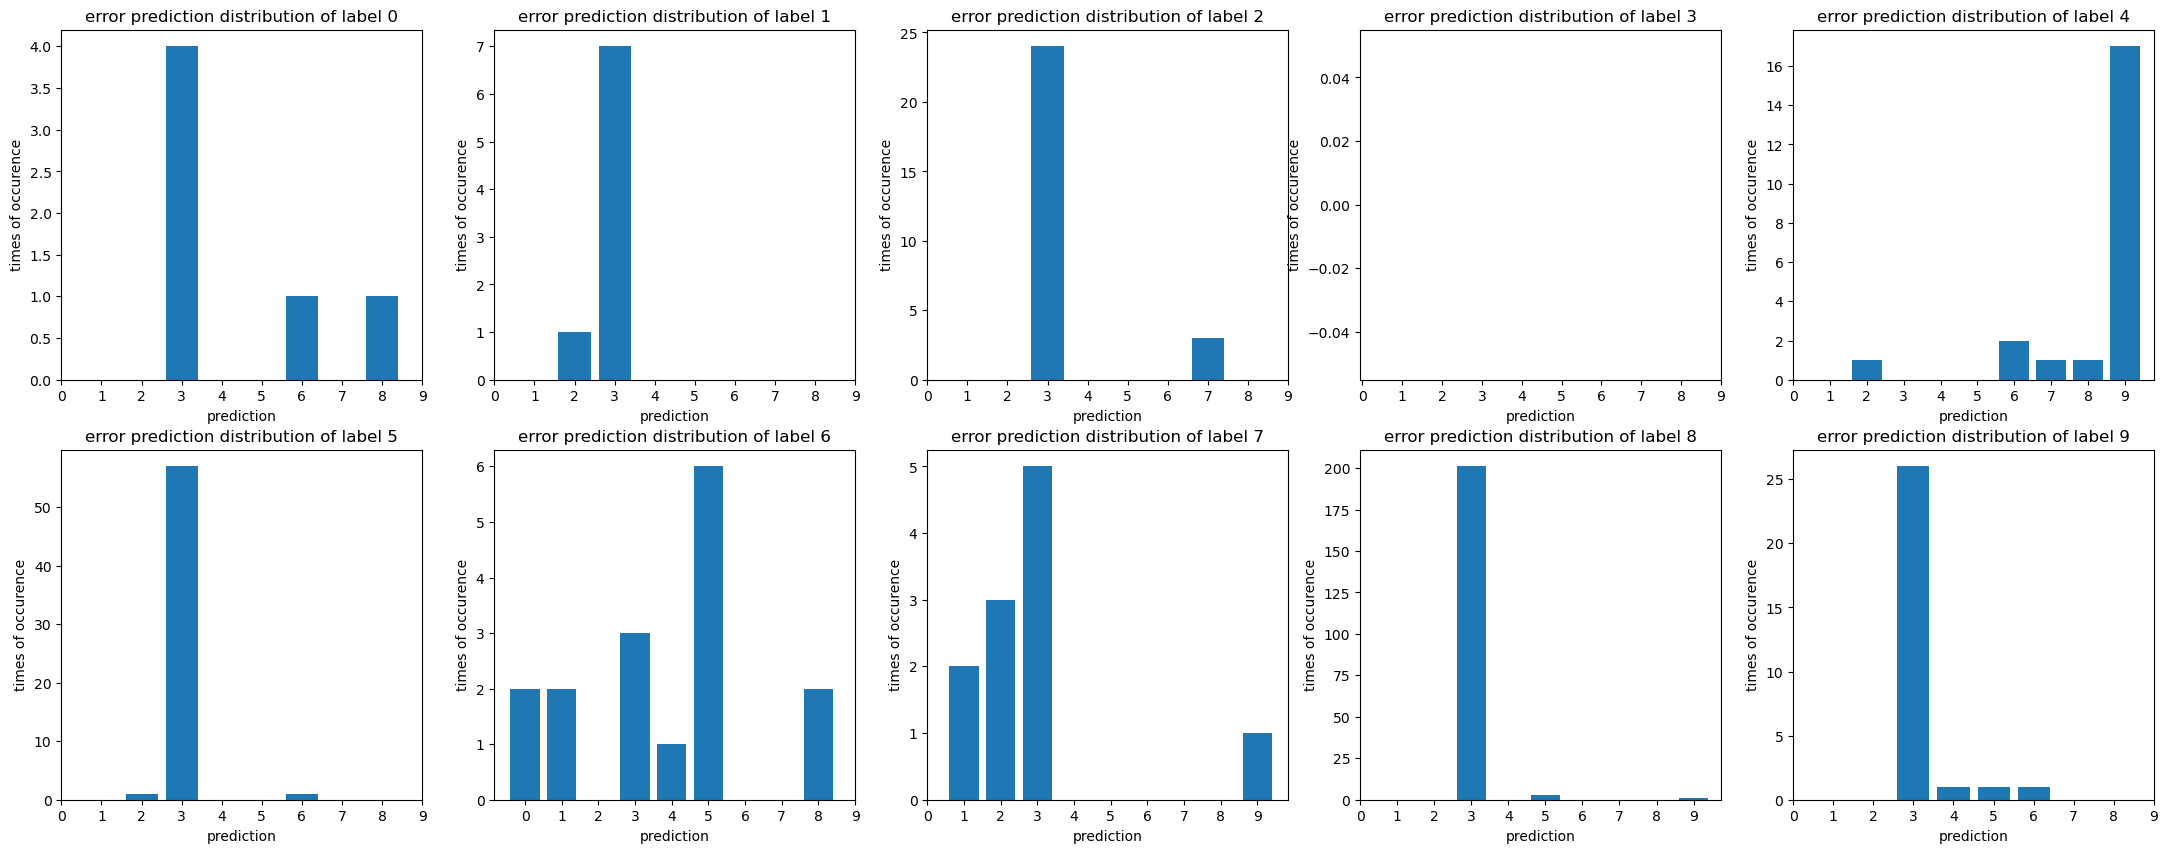

In [36]:
plt.rcParams['figure.figsize'] = [27, 10]

for i in range(10):
    plt.subplot(2, 5, i + 1)

    plt.bar(label_dicts[f'label_dict_{i}'].keys(), label_dicts[f'label_dict_{i}'].values())
    plt.xticks(range(10))
    plt.title(f'error prediction distribution of label {i}')
    plt.xlabel('prediction')
    plt.ylabel('times of occurence')

In [25]:
error_dict = {}

path = os.path.join('error_dict_VGG_epoch40.txt')

with open(path, 'r') as f:
    for line in f:
        key, value1, value2 = line.split()
        error_dict[int(key)] = (int(value1), int(value2))

Text(0, 0.5, 'times of occurence')

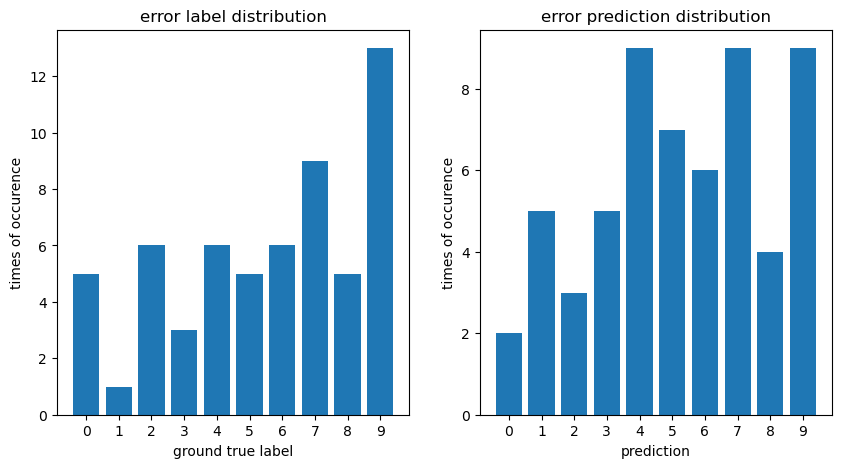

In [26]:
# count: {value: times of occurence}
error_label = {}
for value in error_dict:
    error_label[error_dict[value][0]] = error_label.get(error_dict[value][0], 0) + 1

error_prediction = {}
for value in error_dict:
    error_prediction[error_dict[value][1]] = error_prediction.get(error_dict[value][1], 0) + 1

# plot
plt.rcParams['figure.figsize'] = [10, 5]

plt.subplot(1, 2, 1)
plt.bar(error_label.keys(), error_label.values())
plt.xticks(range(10))
plt.title('error label distribution')
plt.xlabel('ground true label')
plt.ylabel('times of occurence')

plt.subplot(1, 2, 2)
plt.bar(error_prediction.keys(), error_prediction.values())
plt.xticks(range(10))
plt.title('error prediction distribution')
plt.xlabel('prediction')
plt.ylabel('times of occurence')

In [6]:
label_dicts = {}
for i in range(10):
    label_dicts[f'label_dict_{i}'] = {}

for key in error_dict:
    label, prediction = error_dict[key]
    label_dicts[f'label_dict_{label}'][prediction] = label_dicts[f'label_dict_{label}'].get(prediction, 0) + 1

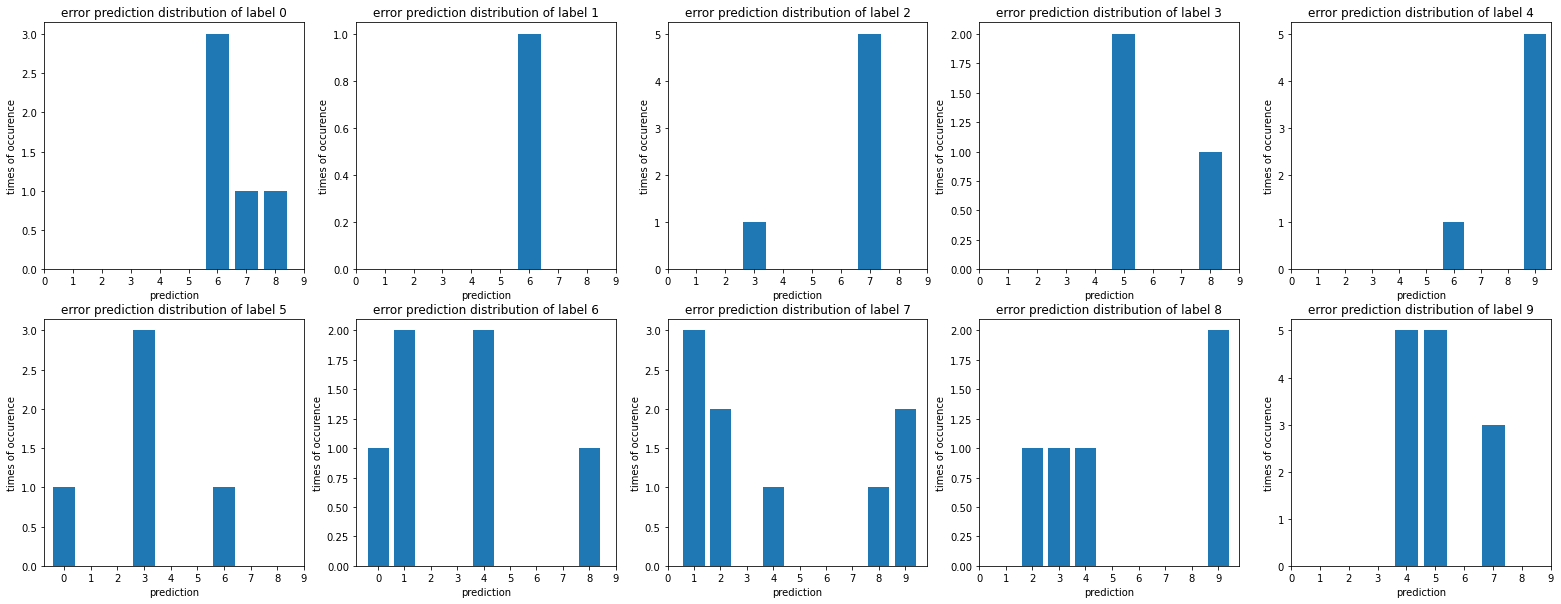

In [7]:
plt.rcParams['figure.figsize'] = [27, 10]

for i in range(10):
    plt.subplot(2, 5, i + 1)

    plt.bar(label_dicts[f'label_dict_{i}'].keys(), label_dicts[f'label_dict_{i}'].values())
    plt.xticks(range(10))
    plt.title(f'error prediction distribution of label {i}')
    plt.xlabel('prediction')
    plt.ylabel('times of occurence')

In [30]:
image = MNIST_train[582][0]
net.eval()
image = image.reshape(1, 1, 224, 224)
result = net(image)

int(torch.argmax(F.softmax(result)))

/var/folders/4z/kspnn2f503550_nfygz4qbr00000gn/T/ipykernel_6605/2873504867.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  int(torch.argmax(F.softmax(result)))


2

In [19]:
error_dict

{115: (4, 9),
 184: (8, 3),
 221: (2, 3),
 241: (9, 3),
 247: (4, 2),
 266: (8, 3),
 268: (8, 3),
 318: (2, 3),
 333: (5, 3),
 338: (8, 3),
 340: (5, 3),
 352: (5, 3),
 397: (5, 3),
 412: (5, 3),
 444: (2, 3),
 445: (6, 0),
 447: (4, 9),
 448: (9, 3),
 469: (5, 3),
 495: (8, 3),
 543: (8, 3),
 582: (8, 3),
 583: (2, 7),
 591: (8, 3),
 606: (8, 3),
 641: (8, 3),
 655: (8, 3),
 659: (2, 7),
 674: (5, 3),
 740: (4, 9),
 800: (8, 3),
 839: (8, 3),
 844: (8, 3),
 876: (8, 3),
 878: (8, 3),
 900: (1, 3),
 936: (8, 3),
 947: (8, 9),
 1003: (5, 3),
 1014: (6, 5),
 1018: (8, 3),
 1039: (7, 3),
 1050: (2, 3),
 1052: (8, 3),
 1074: (8, 3),
 1112: (4, 6),
 1200: (8, 3),
 1226: (7, 2),
 1234: (8, 3),
 1242: (4, 9),
 1247: (9, 3),
 1248: (8, 3),
 1260: (7, 1),
 1287: (8, 3),
 1289: (5, 3),
 1299: (5, 3),
 1312: (8, 3),
 1319: (8, 3),
 1331: (5, 3),
 1339: (5, 3),
 1364: (8, 3),
 1393: (5, 3),
 1394: (8, 3),
 1395: (2, 3),
 1398: (8, 3),
 1414: (9, 3),
 1441: (8, 3),
 1459: (2, 3),
 1466: (5, 3),
 14

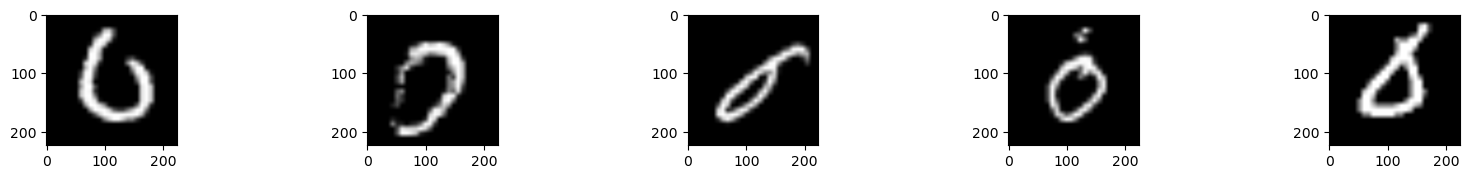

In [38]:
plt.rcParams['figure.figsize'] = [20, 20]

l = 0
count = 0

for key in error_dict:
    label, prediction = error_dict[key]
    if label == l:
        count += 1
        plt.subplot(10, 5, count)
        plt.imshow(MNIST_train[key][0].reshape(224, 224), cmap='gray')
